# Homework 2
### Alex Pine
### akp258@nyu.edu

# Data preprocessing

I tokenized the data by splitting on whitespace. I left in strings of punctuation. I extracted the top 10,000 most frequently occuring words, and replaced all the words that didn't fall into that group with "<oov>". I then wrote code to replace each word with its vocabulary index position, and to pad each review with zeros to the maximum sequence length.

To determine an appropriate sequence length, I made a histogram of the length of the reviews (see below). From this histogram, I decided a maximum length of 700 words per review would be more than enough for accuracte sentiment classification.

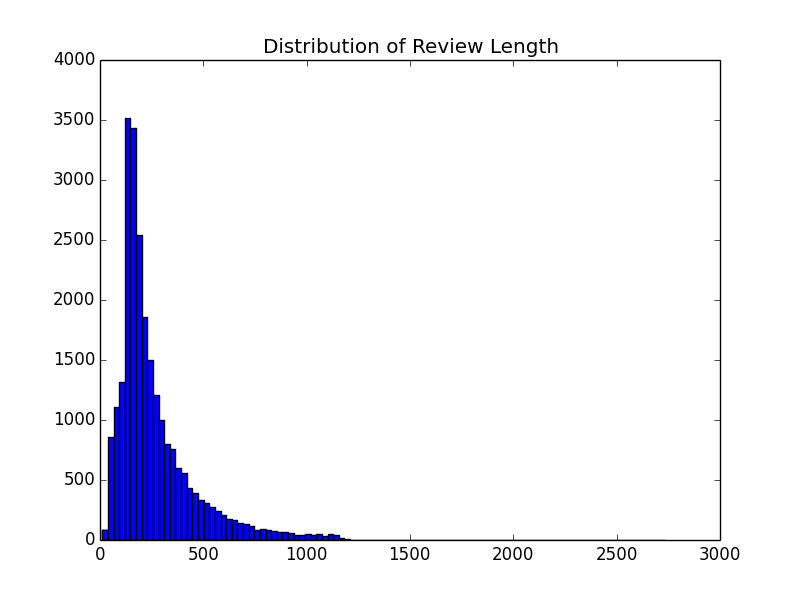

In [2]:
from IPython.display import Image
Image(filename='/Users/pinesol/nlp/hw2/review_len_dist.png') 

## CBOW Unigrams
After cleaning the data, I created a variant of the CBOW model to classify the reviews based on the their given labels. The CBOW model has an embedding matrix that ensures there is one embedding vector for each word in the vocabulary. It transforms the word-index vectors that represent each review into a vector of embeddings. It then takes the average of all these embeddings, and runs it through a fully connected layer with a softmax.

### Results
I ran the CBOW model with the following parameters:

- BATCH_SIZE=32
- EMBEDDING_DIM=64
- SEQUENCE_LENGTH=700
- LEARNING_RATE=0.001
- NUM_EPOCHS=15

It netted the following results:

- Accuracy: 0.893
- Precision 0.861
- Recall 0.938

Below is the graph of training accuracy (green) and testing accuracy (blue) over the course of the training. I only plotted the training accuracy when I evaluated the testing set, so there are fewer training accuracy points than you might otherwise expect.

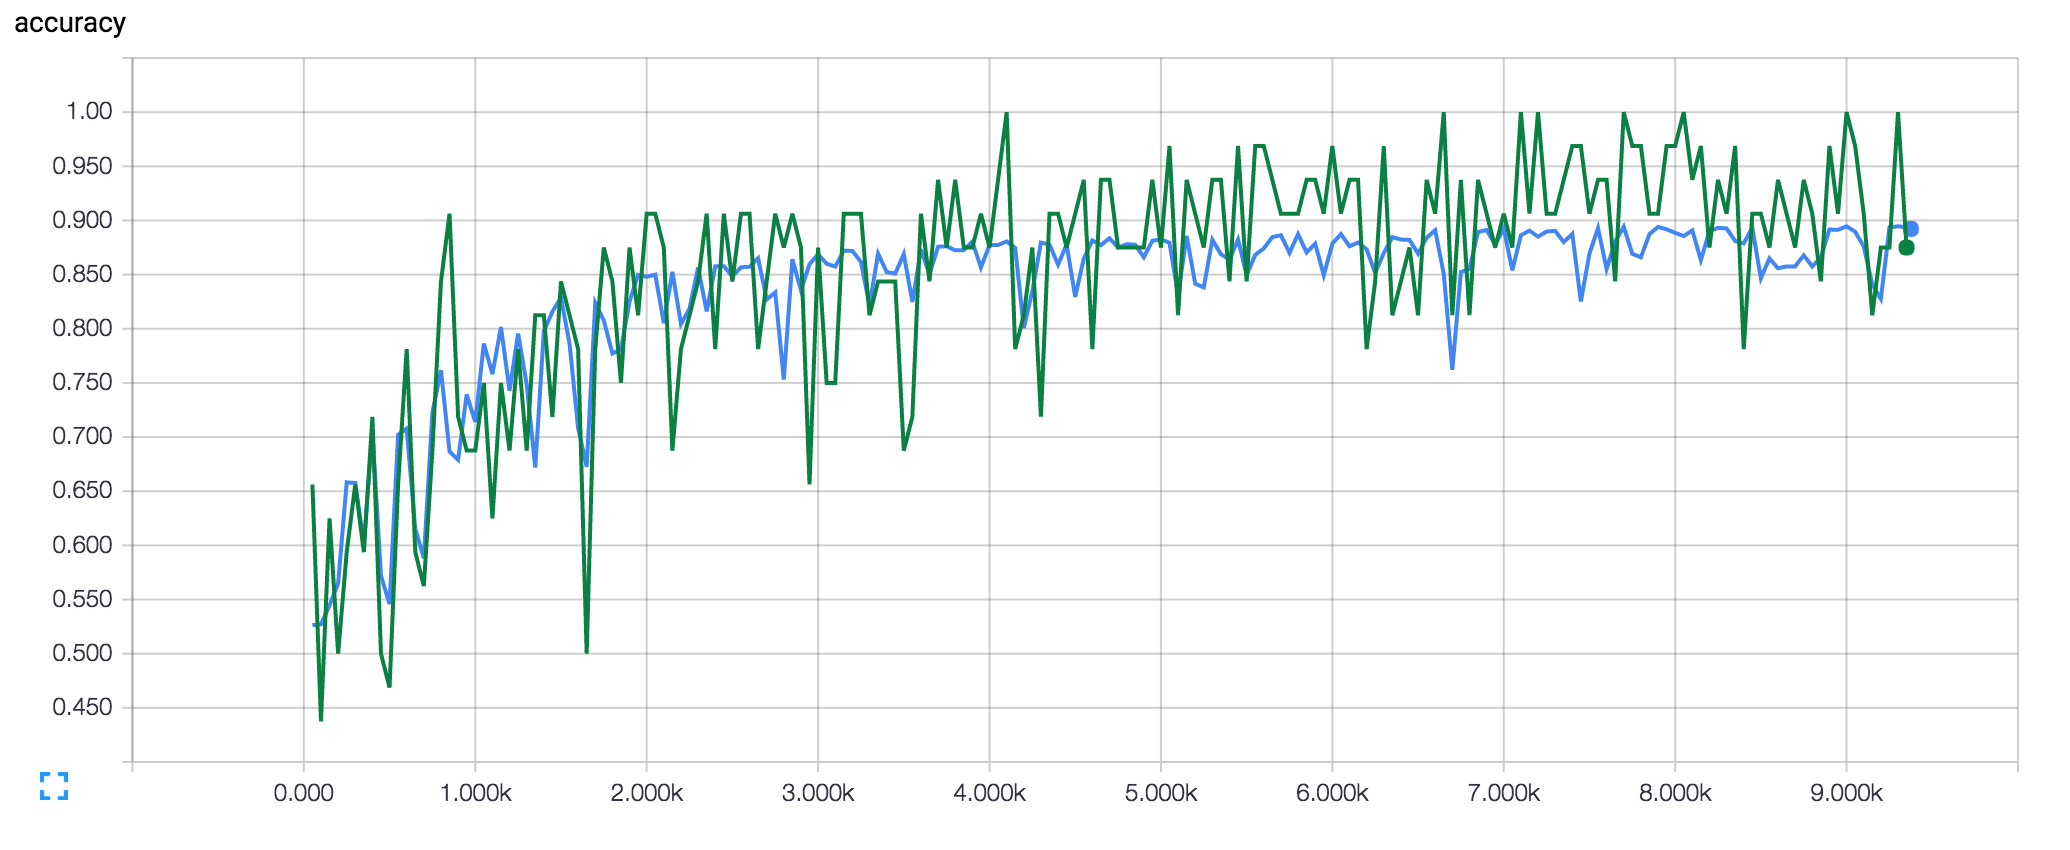

In [3]:
Image(filename='/Users/pinesol/nlp/hw2/first-run-accuracy.png') 

### Discussion

The model seems to work, but the accuracy is more variable than I would like. This could be due to high dimensionality of the embeddings (64) coupled with a relatively small batch size (32).

## CBOW Bigrams

I modified each review to include its bigrams in addition to its unigrams, but only if the bigram was one of the top 10,000 most frequently occuring bigrams. This brought the vocabulary size up to 20,000. Unlike the unigram model, I did not replace uncommon bigrams with "oov". I simply did not include them. I did this because the number of different bigrams is so large, that replacing the infrequent ones with "oov" would ensure the majority of review text would become "oov".

Since each review became a little longer from the new bigrams, I increased the sequence length up to 800 from 700 to accommodate the new words.


- BATCH_SIZE=32
- EMBEDDING_DIM=64
- EVALUATE_EVERY=100
- EXP_NAME=bigrams
- LEARNING_RATE=0.001
- NUM_EPOCHS=15
- SEQUENCE_LENGTH=800

### Results

- Accuracy 0.906
- Precision 0.911
- Recall 0.900

### Discussion
There is a slight improvement between the unigram model and the bigram model. The extra bigrams simply don't add enough new information to significantly improve accuracy. The accuracy appears to be slightly less variable, however.


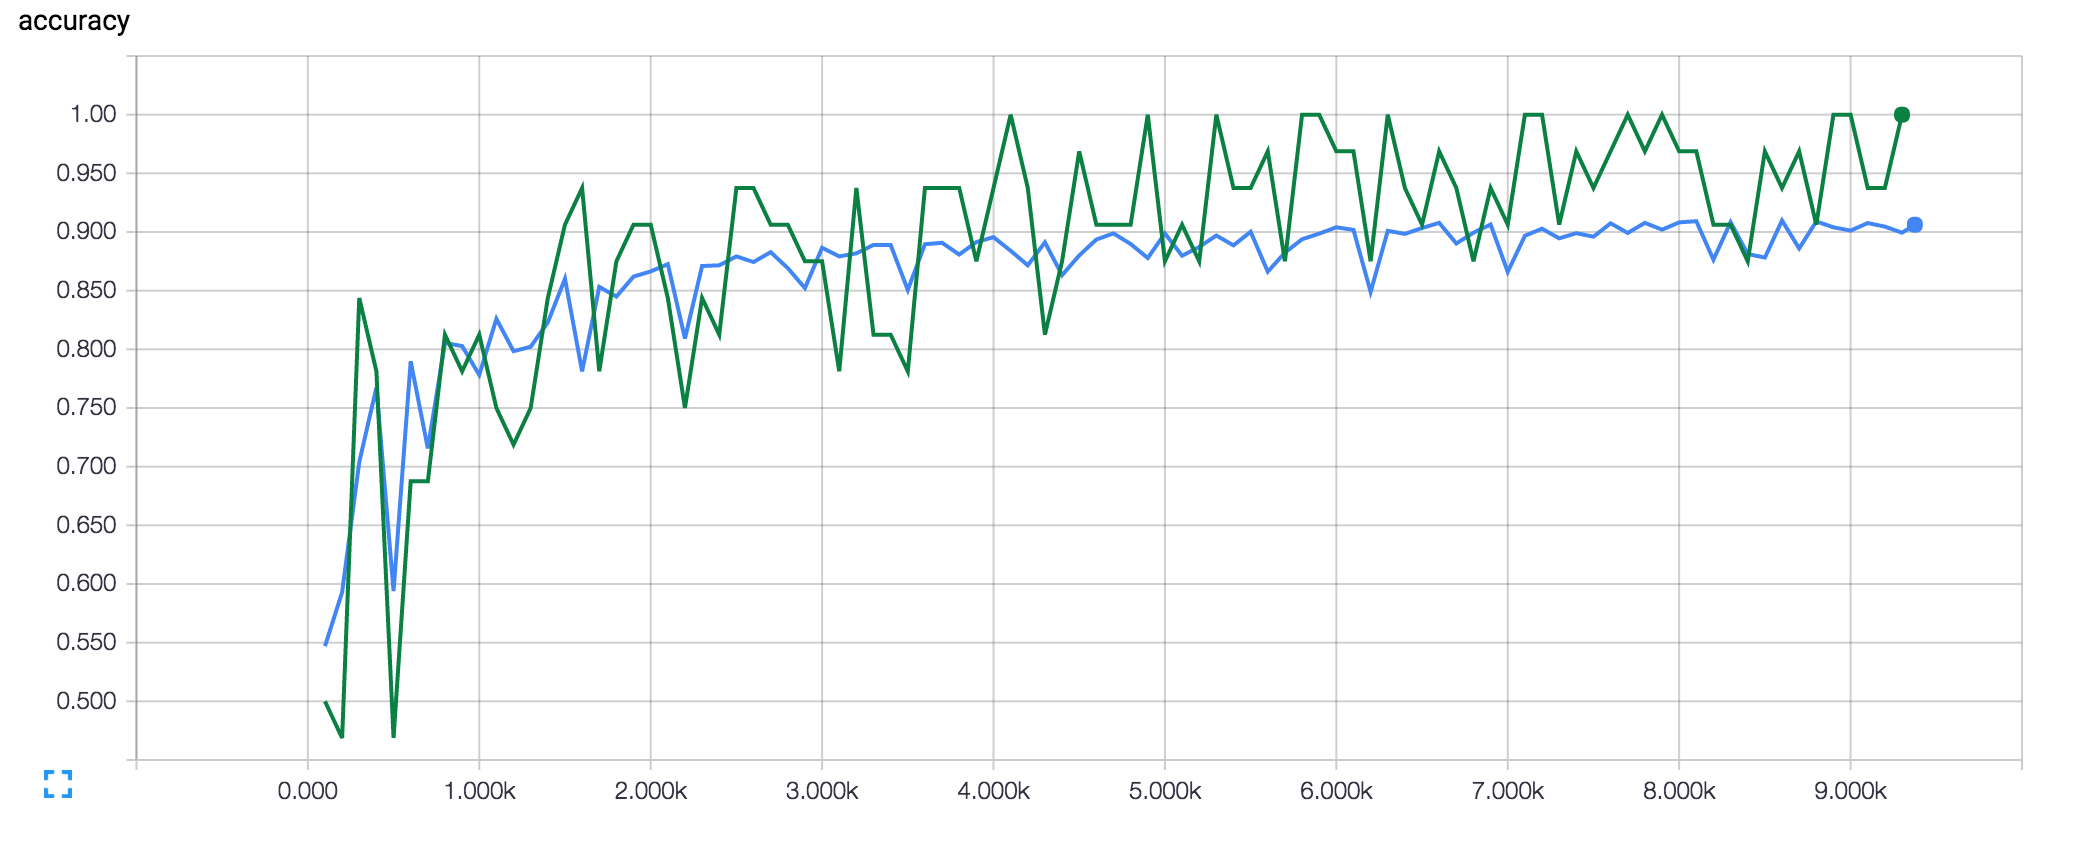

In [8]:
Image(filename='/Users/pinesol/nlp/hw2/bigram-accuracy.png') 

### The "correct" CBOW model

The version of the CBOW model I have implemented is slightly incorrect. In order to make sure each review vector can fit into the model, I pad reviews that have fewer than 700 words with 'null' entries (zeros). When the model transforms its input into a vector of embeddings, it treats these null entries as a real word in the vocabulary, and gives it a corresponding embedding. A more correct model would have zero'd out these embeddings so that they don't affect the mean calculation. 

Additionally, my model treats the length of each review as the same when calculating the mean of all the embeddings, even though the reviews are different lengths. A more correct model would have used the true length of each review when calculating the mean.

I attempted to implement all of this, but I failed to get it to work. My mistake was that I tried to implement the additional calculations in Tensorflow. This caused the model to try to backprop through all the new intermediate nodes, which it failed to be able to do, complaining with an error I could not decipher. I could not figure out how to stop it from backpropigating the error back through these calculations. 

I should have implemented the required calcuating outside of Tensorflow, passing the required 'mask' matrices as an input. I would have done this, but I ran out of time.

## Fasttext

To prepare the reviews data for the Fasttext model, I wrote code to read each review file into memory, tranformed it to be a single line, and prepended it with either '\__label\__0' (positive) or '\__label\__1' (negative). Then I shuffled the reviews, split them up 80/20, and wrote them to a training file and a testing file.

I experimented with several different sets of parameters. I found the following configuration to give the highest precision and recall:

- dim: 10
- lr: 0.1
- wordNgrams: 2
- minCount: 1
- bucket: 10000000
- epoch: 200
- thread: 4

### Results

This configuration gave a precision/recall score of 88.3%. 

### Discussion

It was surprising to find that an embedding with such a comparatively low dimension (10 vs my 64) could do essentially as well as my model. I also found that increased the minCount parameter didn't seem to help. I also found that using bigrams only gave a 1% increase in precision/recall, which is similar to my model. 

I was also surprised to find that the model trained far more quickly than mine did. This model has clearly been optimized for speed.

Experimenting with the fasttext model made me realize that the 'correct' implementation of CBOW that I described earlier would have apparently not been any better than my model, since the fasttext model does not signifcantly outperform mine. This is likely because binary classification is a simple task for such a powerful model. One would expect the 'correct' version to perform better than my model on more complex tasks.

## A faster model

After seeing the success of the fasttext with a smaller embedding size, I decided to modify my model to see if I could match its speed and accuracy by reducing the embedding size and sequence length. 

### Parameters
- embedding_dim: 8 
- sequence_length: 300 
- bigrams


### Results
- Accuracy: 0.893
- Precision: 0.884
- Recall: 0.903

The new model is just barely less accurate than by earlier bigram model, but it trains far more quickly. And even better, the valdiation accuracy is far less variable, as evidenced by the training graph below. Clearly, a model should be made as simple as possible.

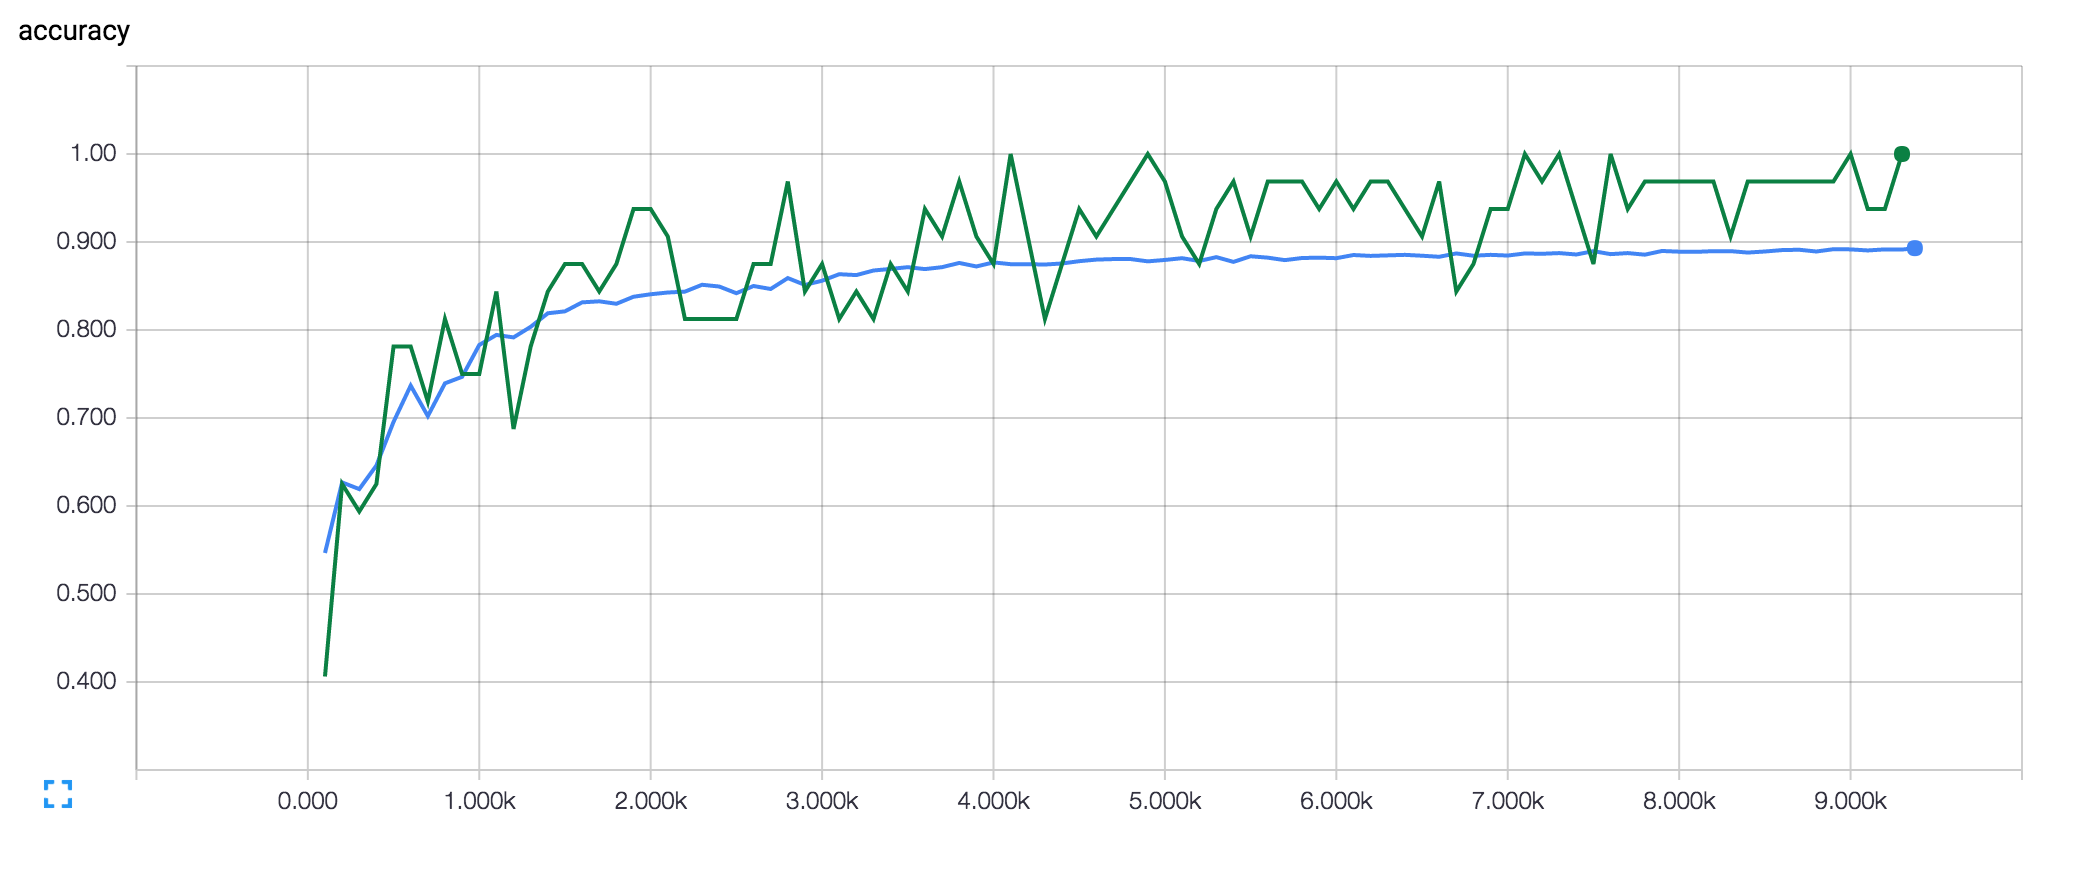

In [9]:
Image(filename='/Users/pinesol/nlp/hw2/fast-accuracy.png') 